# 多次元正規分布

- 2次元正規分布の当てはめ
- 共分散の意味
- 共分散行列と誤差楕円
- 変数の和に対するガウス分布の合成(?)
- ガウス分布同士の積

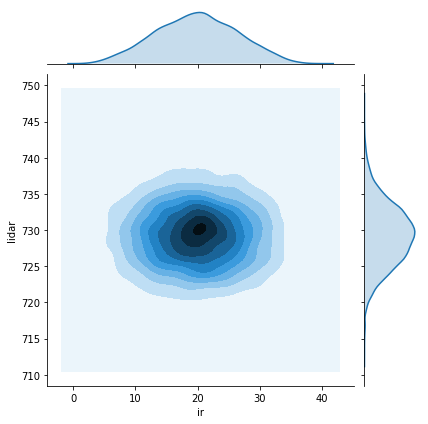

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv(
    '../data/range_sensor/sensor_data_700.txt',
    delimiter=' ',
    header=None,
    names=('date', 'time', 'ir', 'lidar'))

# 12時から16時のデータを抽出
# ほぼガウス分布に従うところを恣意的に選択
h_12 = 120000
h_16 = 160000
data_from_12_to_16 = data[(h_12 <= data['time']) & (data['time'] < h_16)]
ir_and_lidar_from_12_to_16 = data_from_12_to_16.loc[:, ['ir', 'lidar']]

sns.jointplot(
    ir_and_lidar_from_12_to_16['ir'],
    ir_and_lidar_from_12_to_16['lidar'],
    ir_and_lidar_from_12_to_16,
    kind='kde')
plt.show()

このヒストグラムを同時確率分布と考えてガウス分布に当てはめることを考える

$x$をir、$y$をlidarとするセンサ値のベクトルを${\bf z}_{i}$とすると、

$$
    {\bf z}_{IR, Li} = \{ {\bf z}_{i} = \left( x_{i} y_{i} \right)^{\top} \mid i = 0,1,2, \cdots N-1\}
$$

多次元ガウス分布

$$
    p({\bf z}) = \frac{1}{(2\pi)^{\frac{n}{2}}\sqrt{\mid \Sigma \mid}} \exp \biggr\{- \frac{1}{2} \left({\bf x - \boldsymbol\mu} \right)^{\top} \Sigma^{-1} \left({\bf x - \boldsymbol\mu} \right) \biggl\}
$$

$n = 1$として$\Sigma$を$\sigma^{2}$とすると1次元のものと一致する

なので、$\Sigma$は広がりを表すパラメータっぽい

${\bf z}_{IR, Li}$に最もよく当てはまるガウス分布を求めてみる

-> $\Sigma$と$\boldsymbol\mu$を求めることと等価


共分散行列
$$
    \Sigma = \left(
        \begin{array}{cc}
            \sigma_{x}^{2} & \sigma_{xy} \\
            \sigma_{yx} & \sigma_{y}^{2}
        \end{array}
    \right) \\
    \\
    \sigma_{xy} = \frac{1}{N - 1} \sum_{i=0}^{N-1} \left(x_{i} - \mu_{x} \right) \left(y_{i} - \mu_{y} \right)
$$

In [13]:
print('Mean of IR: {}'.format(ir_and_lidar_from_12_to_16.ir.mean()))
print('Mean of Li: {}'.format(ir_and_lidar_from_12_to_16.lidar.mean()))
print('Variance of IR: {}'.format(ir_and_lidar_from_12_to_16.ir.var()))
print('Variance of Li: {}'.format(ir_and_lidar_from_12_to_16.lidar.var()))

diffs_ir = ir_and_lidar_from_12_to_16.ir - ir_and_lidar_from_12_to_16.ir.mean()
diffs_li = ir_and_lidar_from_12_to_16.lidar - ir_and_lidar_from_12_to_16.lidar.mean()

a = diffs_ir * diffs_li
cov = sum(a) / (len(ir_and_lidar_from_12_to_16) - 1)
print('Covariance of IR and Lidar (12-16): {}'.format(cov))

Mean of IR: 19.860246913580248
Mean of Li: 729.3119576719577
Variance of IR: 42.117126367701594
Variance of Li: 17.702026469211457
Covariance of IR and Lidar (12-16): -0.31677803385436953


ということで、

$$
\boldsymbol\mu = \left(
    \begin{array}{c}
            19.89 \\
            729.3
        \end{array}
    \right) \\
    \\
\Sigma = \left(
    \begin{array}{cc}
            42.12 & -0.3168 \\
            -0.3168 & 17.70
        \end{array}
    \right) \\
    \\
$$

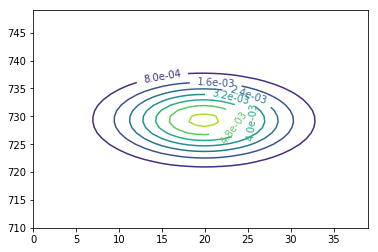

In [18]:
# 分布の可視化
from scipy.stats import multivariate_normal
import numpy as np

ir_lidar = multivariate_normal(
    mean=ir_and_lidar_from_12_to_16.mean().values.T, 
    cov=ir_and_lidar_from_12_to_16.cov().values)

# 描画用の2D空間を作る
# x: 0 - 40
# y: 710 - 750
x, y = np.mgrid[0:40, 710: 750]
# 40 x 40 x 2次元のpos
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
cont = plt.contour(x, y, ir_lidar.pdf(pos))
cont.clabel(fmt='%1.1e')

plt.show()

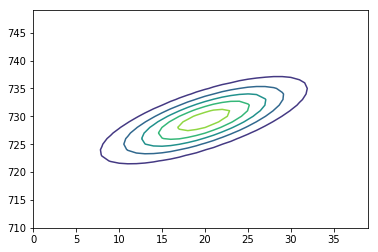

In [21]:
# covをいじって分布を見てみる
# sigma_xyに20足してみる
c = ir_and_lidar_from_12_to_16.cov().values + np.array([[0, 20], [20, 0]])
tmp = multivariate_normal(
    mean=ir_and_lidar_from_12_to_16.mean().values.T,
    cov=c)
cont = plt.contour(x, y, tmp.pdf(pos))

plt.show()

covを増やしたらIRセンサの値が高いとLidarの値も高い傾向があるような分布になった

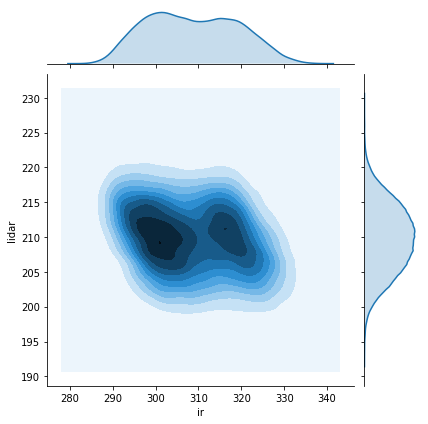

In [25]:
# 別な距離のデータで、24Hのデータを正規分布に当てはめてみる

data = pd.read_csv(
    '../data/range_sensor/sensor_data_200.txt',
    delimiter=' ',
    header=None,
    names=('date', 'time', 'ir', 'lidar'))

ir_and_lidar_200 = data.loc[:, ['ir', 'lidar']]
sns.jointplot(
    ir_and_lidar_200.ir,
    ir_and_lidar_200.lidar,
    ir_and_lidar_200,
    kind='kde')
ir_and_lidar_200.cov()
plt.show()

In [30]:
def create_grid(x_min, x_max, y_min, y_max):
    x, y = np.mgrid[x_min:x_max, y_min:y_max]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    return x, y, pos

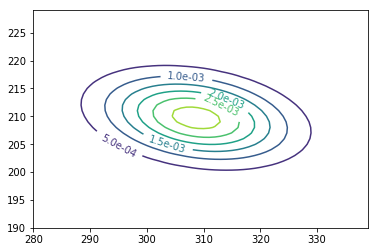

In [33]:
ir_lidar = multivariate_normal(
    mean=ir_and_lidar_200.mean().values.T,
    cov=ir_and_lidar_200.cov().values)
x, y, pos = create_grid(280, 340, 190, 230)
cont = plt.contour(x, y, ir_lidar.pdf(pos))
cont.clabel(fmt='%1.1e')

plt.show()

右肩下がり

-> 片方が平均より大きい場合に、もう片方は平均より小さくなる傾向

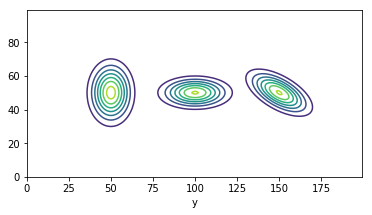

In [37]:
# 2D正規分布3種
%matplotlib inline
from math import sqrt

x, y, pos = create_grid(0, 200, 0, 100)

means = [
    [50, 50],
    [100, 50],
    [150, 50]]
covs = [
    [[50, 0],
     [0, 100]],
    [[125, 0],
     [0, 25]],
    [[100, -25. * sqrt(3)],
     [-25. * sqrt(3), 50]]]

dists = []
for m, c in zip(means, covs):
    dist = multivariate_normal(mean=m, cov=c)
    dists.append(dist)
    plt.contour(x, y, dist.pdf(pos))
    
plt.gca().set_aspect('equal')
plt.gca().set_xlabel('x')
plt.gca().set_xlabel('y')
plt.show()

$\sigma_{xy}$があると分布は回転する

分布の傾きについて調べてみる

In [44]:
# 固有値・固有ベクトル
eig_vals, eig_vec = np.linalg.eig(dists[2].cov)

print('eigen values = {}'.format(eig_vals))
print('eigen vector = {}'.format(eig_vec))

v1 = eig_vec[:, 0]
v2 = eig_vec[:, 1]
print('eigen vec 1  = {}'.format(v1))
print('l2 norm of eigen vec 1 = {}'.format(np.linalg.norm(v1)))
print('eigen vec 2  = {}'.format(v2))
print('l2 norm of eigen vec 2 = {}'.format(np.linalg.norm(v2)))

eigen values = [125.  25.]
eigen vector = [[ 0.8660254  0.5      ]
 [-0.5        0.8660254]]
eigen vec 1  = [ 0.8660254 -0.5      ]
l2 norm of eigen vec 1 = 1.0
eigen vec 2  = [0.5       0.8660254]
l2 norm of eigen vec 2 = 1.0


固有値

$$
l_{1} = 125 \\
l_{2} = 25
$$

固有ベクトル

$$
{\bf v}_{1} = \left(
    \begin{array}{cc}
        \frac{\sqrt(3)}{2} \\
        - \frac{1}{2}
    \end{array}
\right) \\
\\
{\bf v}_{2} = \left(
    \begin{array}{cc}
        \frac{1}{2} \\
        \frac{\sqrt{3}}{2}
    \end{array}
\right) \\
\\
$$

ベクトル$\sqrt{l_{1}}{\bf v}_{1}, \sqrt{l_{2}}{\bf v}_{2}$を追記してみる

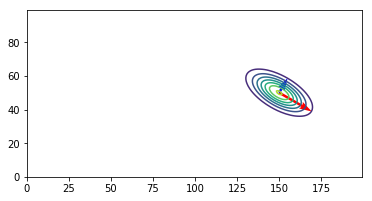

In [51]:
plt.contour(x, y, dists[2].pdf(pos))

# 見やすいように2倍に
vec_gain = 2.
vecs_for_plot = []
for eigen_val, eigen_vec in zip(eig_vals, [v1, v2]):
    vecs_for_plot.append(vec_gain * sqrt(eigen_val) * eigen_vec)
    
colors = ['red', 'blue']
for vec, color in zip(vecs_for_plot, colors):
    # 始点は平均値
    plt.quiver(
        means[2][0], means[2][1], vec[0], vec[1],
        color=color, angles='xy', scale_units='xy', scale=1)
    
plt.gca().set_aspect('equal')
plt.show()

$\Sigma$と固有ベクトル、固有値の関係

$$
\Sigma = VLV^{\top} \\
V = \left(
    \begin{array}{c}
            {\bf v}_{1} & {\bf v}_{2} \\
    \end{array}
\right) \\
\\
L = \left(
    \begin{array}{cc}
            l_{1} & 0 \\
            0     & l_{2}
    \end{array}
\right) \\
$$

ためしに検算

In [60]:
V = eig_vec
L = np.diag(eig_vals)

print('VLV^(-1) \n{}'.format(V @ L @ np.linalg.inv(V)))
print('original \n{}'.format(dists[2].cov))

print('ちなみに')

print('dist[1].cov \n{}'.format(dists[1].cov))
print('L of dists[2] \n{}'.format(L))

print('となり一緒。Vは回転行列なので、dists[2]はdists[1]を回転させたものと考えることができる')

VLV^(-1) 
[[100.         -43.30127019]
 [-43.30127019  50.        ]]
original 
[[100.         -43.30127019]
 [-43.30127019  50.        ]]
ちなみに
dist[1].cov 
[[125.   0.]
 [  0.  25.]]
L of dists[2] 
[[125.   0.]
 [  0.  25.]]
となり一緒。Vは回転行列なので、dists[2]はdists[1]を回転させたものと考えることができる


なぜ、dists\[1\].covの両側を回転行列で挟むと分布が回転するのか

$$
\Sigma = R_{\theta}LR_{\theta}^{\top}
$$

この逆行列は

$$
\Sigma^{-1} = R_{\theta}L^{-1}R_{\theta}^{\top}
$$

これを$n=2$のときの多次元正規分布の式に代入

$$
\begin{eqnarray}
p(x) &=& \frac{1}{2\pi\sqrt{\mid \Sigma \mid}} \exp \biggl\{ - \frac{1}{2} \left({\bf x - \boldsymbol\mu} \right)^{\top} \Sigma^{-1} \left({\bf x - \boldsymbol\mu} \right)  \biggr\} \\
&=& \frac{1}{2\pi\sqrt{\mid R_{\theta}LR_{\theta}^{-1} \mid}} \exp \biggl\{ - \frac{1}{2} \left({\bf x - \boldsymbol\mu} \right)^{\top} R_{\theta}L^{-1}R_{\theta}^{\top} \left({\bf x - \boldsymbol\mu} \right)  \biggr\}
\end{eqnarray}
$$

行列式の性質により

$$
\mid R_{\theta}LR_{\theta}^{-1} \mid = \mid L \mid
$$

座標変換(並進からの回転）

$$
{\bf x}^{\prime} = R_{\theta}^{-1}\left({\bf x - \boldsymbol\mu} \right) 
$$

転置の性質（転置させたければ、いれかえてそれぞれ転置）

$$
{\bf x}^{\prime\top} =\left({\bf x - \boldsymbol\mu} \right)^{\top} R_{\theta}
$$

すると

$$
p(x) = \frac{1}{2\pi\sqrt{\mid L \mid}} \exp \biggl\{ - \frac{1}{2} {\bf x}^{\prime\top} L^{-1} {\bf x}^{\prime} \biggr\} = \mathit{N}\left({\bf x}^{\prime}, L\right)
$$